# Imports

In [312]:
import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create graph

In [313]:
start_coords = (53.472075, -2.238855)
target_coords = (53.47, -2.24)

In [314]:
# Get data from open street maps and plot network
G = ox.graph_from_point(start_coords, dist=2000, network_type="drive", simplify=True)

In [315]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [316]:
start_node = ox.distance.nearest_nodes(G, Y=start_coords[0], X=start_coords[1]) # Dalton Building
destination_node = ox.distance.nearest_nodes(G, Y=target_coords[0], X=-target_coords[1]) # Destination

# Setup

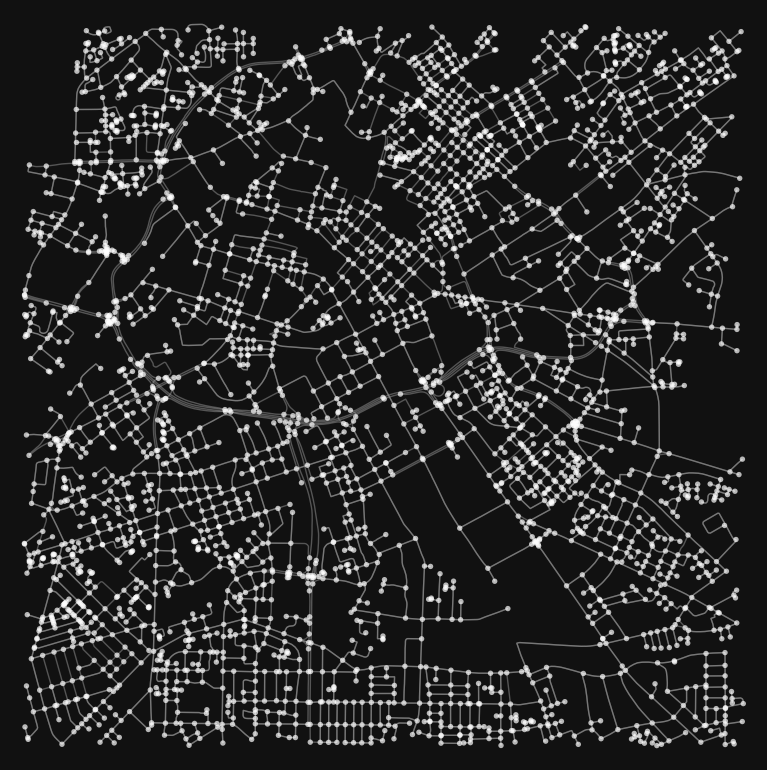

In [317]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8),facecolor="#111111");
ax.set_facecolor("#111111")
# Remove all margins
ax.margins(0)
plt.tight_layout(pad=0)

fig, ax, scatter = ox.plot_graph(G, ax=ax, node_alpha=0.7, edge_alpha=0.5);

# Create a list of nodes and get the number of points in the graph.
nodes = list(G.nodes())
num_points = len(list(G))

# Create a dictionary of adjacent node for efficient look-up.
adj_dict = {n: adjacent_node_dict for n, adjacent_node_dict in G.adjacency()}

# Visualising

In [318]:
# Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

# Initially set sizes and colours to defaults (size 10, colour white)
sizes = [10 for i in range(num_points)]
colours = ["#FFFFFF" for i in range(num_points)] 

def update_graph_visuals(current_node, closed_set):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''
    
    # Loop through all closed (visited) nodes and set them to yellow and size 10
    if len(closed_set) > 1:
        sizes[node_index_map[closed_set[-2]]] = 10
        colours[node_index_map[closed_set[-2]]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[destination_node]] = "#FF00FF"
    sizes[node_index_map[destination_node]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"

    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

In [319]:
class Node():
    def __init__(self, node_id):
        self.node_id = node_id

# Searching

In [320]:
class SearchClass:
    def __init__(self, start_node, destination_node):
        self.start = start_node
        self.destination = destination_node
        self.done = False

        self.open = [start_node]
        self.closed = []
        
        self.edges_traveled = []

    def reset(self):
        self.done = False
        self.open = [self.start]
        self.closed = []

    def animate_search(self, search_type):
        # Animation function
        def animate(frame):
            next_node = self.search_step(search_type)
            update_graph_visuals(next_node, self.closed)
            return scatter
        
        # Frame generator: Stops yielding when .done
        def frame_generator():
            frame = 0
            while not self.done:
                yield frame
                frame += 1

        # Create the animation using the generator
        ani = animation.FuncAnimation(fig, animate, frames=frame_generator, interval=200, save_count=num_points)

        # Save the animation
        ffmpeg_writer = animation.FFMpegWriter(fps=10)
        ani.save(search_type + "_manchester.mp4", writer=ffmpeg_writer)

    def search_step(self, search_type):
        if self.done: return self.destination
        node = self.pick_node(search_type)
        self.done = (node == self.destination)
        self.open.extend([key for key in adj_dict[node].keys() if key not in self.closed])
        self.closed.append(node)

        return node
    
    def pick_node(self, search_type):
        if search_type == "dfs":
            return self.open.pop(-1)
        if search_type == "bfs":
            print("Popping from back.")
            return self.open.pop(0)

# Running

In [321]:
searcher = SearchClass(start_node, destination_node)

In [322]:
searcher.animate_search(search_type="bfs")
searcher.animate_search(search_type="dfs")

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>Breadth First
        <br>
        <video src="bfs_manchester.mp4" alt="bfs" width="500" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>Depth First
        <br>
        <video src="dfs_manchester.mp4" alt="bfs" width="500" controls/>
    </div>
</div>
